In [1]:
!pip install -q kaggle

In [ ]:
!pip install kaggle --upgrade

In [3]:
#import google dependence to read files from google drive
!pip install -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#authenticate

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Let's be rebels and ignore warnings for now
import warnings 
warnings.filterwarnings('ignore')

raw = drive.CreateFile({'id': '1iVn4WhmZoq7lWgB1cPE6F8LzkQbf1dQ8'})
raw.GetContentFile('kaggle.json')

In [4]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c web-traffic-time-series-forecasting

In [8]:
!unzip train_1.csv.zip

Archive:  train_1.csv.zip
  inflating: train_1.csv             


In [9]:
import pandas as pd
import numpy as np
import datetime
import re
import seaborn as sns
import calendar
from tqdm import tqdm
from tqdm import tnrange 
from collections import Counter
from scipy.fft import fft
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler


In [10]:
train = pd.read_csv('train_1.csv')
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


As seen above that there is lot of missing value present to find total number missing value present summing all the data

In [11]:
train.isna().sum() 

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

In [11]:
#filling the Nan with Zero right now but it will deal later

train = train.fillna(0)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


<h3>Exploratory Data Analysis</h3>

Is trafic affected by Page language?

Look for the different languages present in wikipedia page which might affect the dataset by using simple regular expression. There are some non wikipedia pages, these are wikimedia pages, so given them the code 'na' since, haven't determined their language. Many of these will be things like images that do not really have a language.

In [12]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

train['lang'] = train.Page.map(get_language)

In [14]:
print(Counter(train.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


There are 7 languages plus the media pages. The languages used here are: English, Japanese, German, French, Chinese, Russian, and Spanish

Create dataframes for the different types of entries. After that calculate the sum of all views. The data comes from several different sources, the sum will likely be double counting some of the views.

In [13]:
lang_sets = {}
lang_sets['en'] = train[train.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train[train.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train[train.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train[train.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train[train.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train[train.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train[train.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train[train.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

Now looks how does the total number of views change over time?

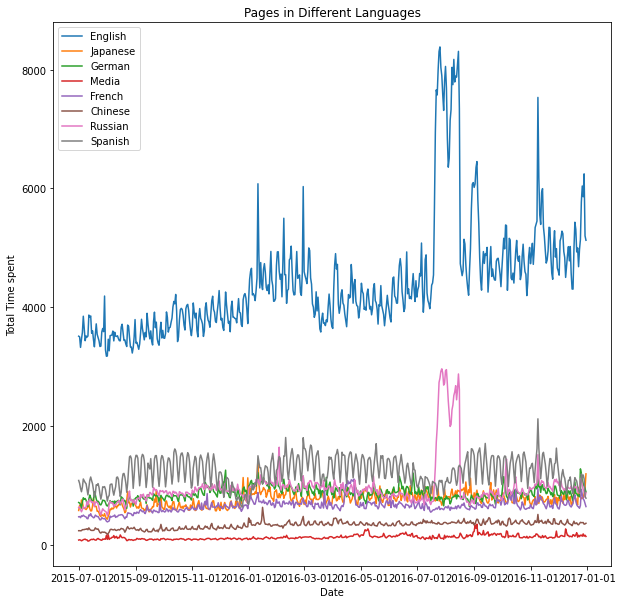

In [22]:
import matplotlib.dates as mdates
import datetime as dt
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Total Time spent')
plt.xlabel('Date')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in train.columns[1:551]]
for key in sums:
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.plot(x,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

Conclusion:

English shows a much higher number of views per page. There is a lot more structure here than expected. The English and Russian plots show very large spikes around day 400 (around August 2016), with several more spikes in the English data later in 2016. My guess is that this is the effect of both the Summer Olympics in August and the election in the US.

There's also a strange feature in the English data around day 200.

The Spanish data is very interesting too. There is a clear periodic structure there, with a approx 1 week fast period and what looks like a significant dip around every 6 months or so.

<h3>Periodic Structure and FFTs</h3>

Since it looks like there is some periodic structure here, plot each of these separately so that the scale is more visible. Along with the individual plots, I will also look at the magnitude of the Fast Fourier Transform (FFT). Peaks in the FFT show us the strongest frequencies in the periodic signal.


In [17]:
#plotted a views per page in a days first 
def plot_with_views(key):

    fig = plt.figure(1,figsize=[15,5])
    plt.ylabel('Total time spent')
    plt.xlabel('Dates')
    plt.title(labels[key])
    plt.plot(x,sums[key],label = labels[key] )
    plt.show()



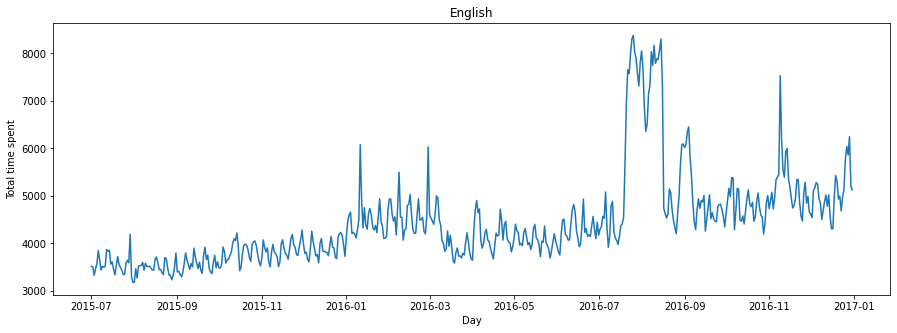

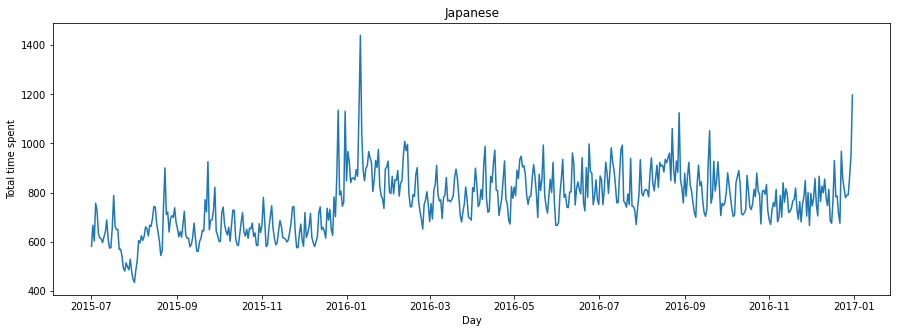

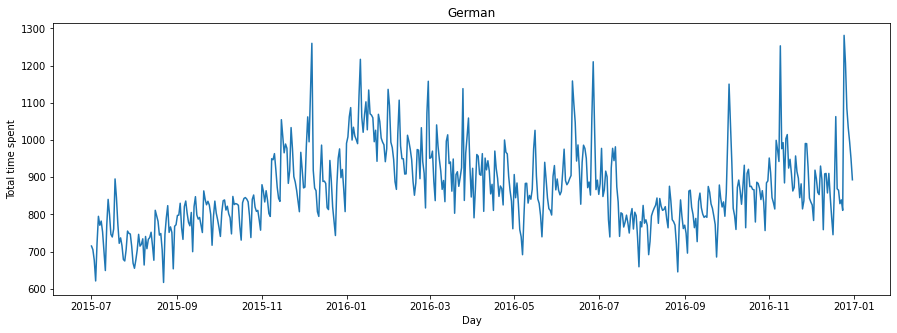

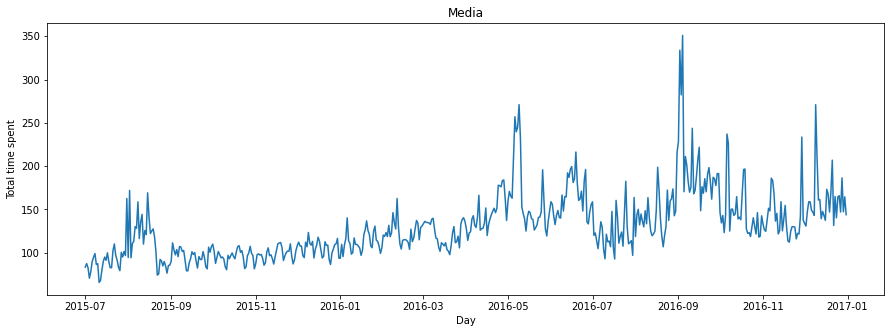

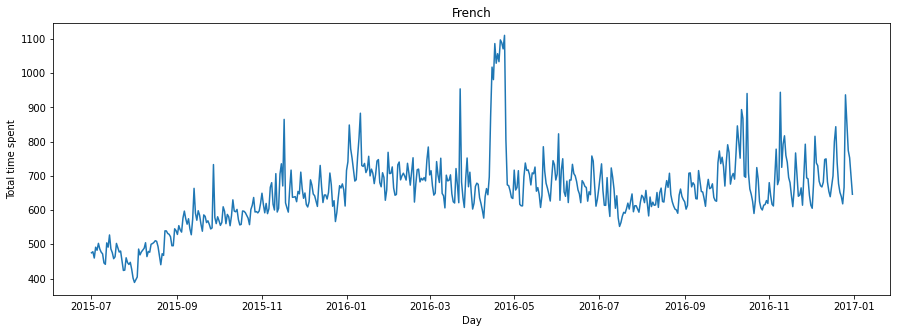

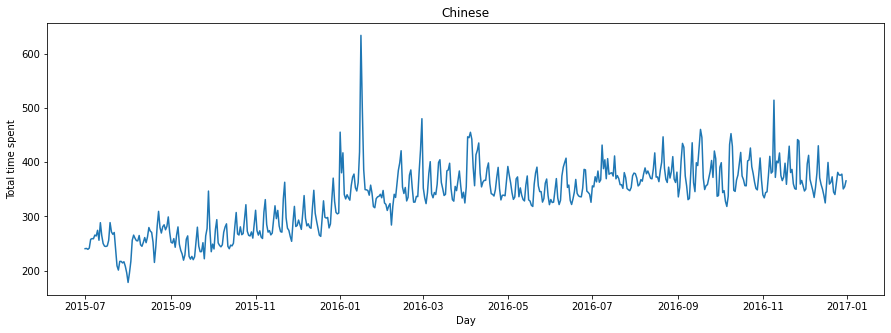

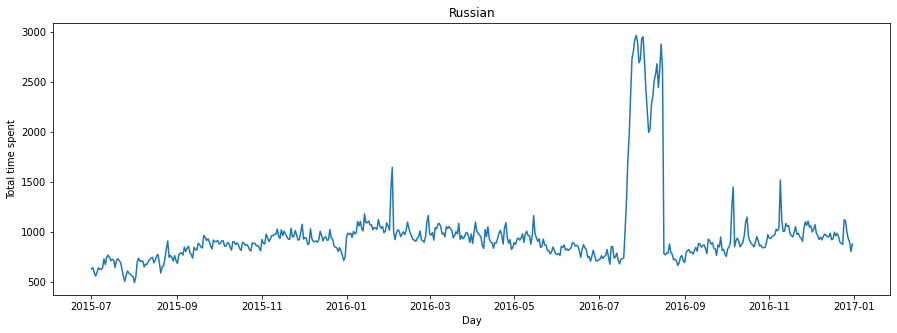

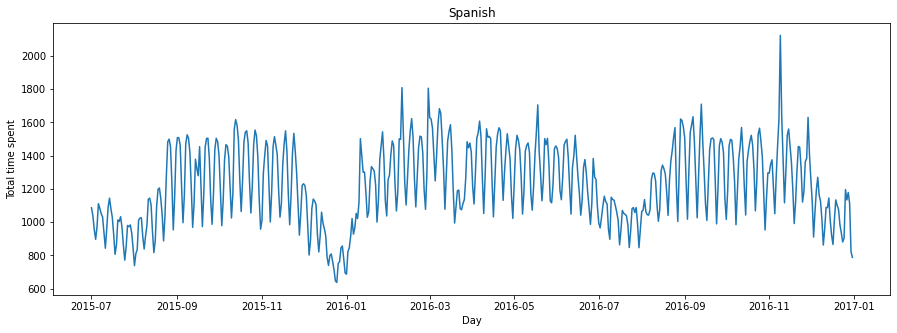

In [18]:
for key in sums:
    plot_with_views(key)

In [19]:

def plot_with_fft(keys):
    fig = plt.figure(2,figsize=[15,5])
    fft_complex = fft(sums[key].values)
    
    
    fft_mag = [np.sqrt(np.real(x)*np.real(x)+np.imag(x)*np.imag(x)) for x in fft_complex]
    fft_xvals = [day / days[-1] for day in days]
    npts = len(fft_xvals) // 2 + 1
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
        
    plt.ylabel('FFT Magnitude')
    plt.xlabel(r"Frequency [days]$^{-1}$")
    plt.title('Fourier Transform')
    plt.plot(fft_xvals[1:],fft_mag[1:],label = labels[key] )
    # Draw lines at 1, 1/2, and 1/3 week periods
    plt.axvline(x=1./7,color='red',alpha=0.3)
    plt.axvline(x=2./7,color='red',alpha=0.3)
    plt.axvline(x=3./7,color='red',alpha=0.3)
    plt.show()

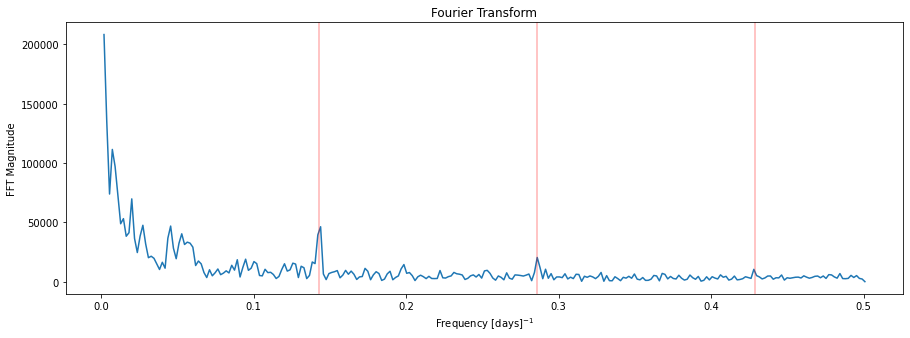

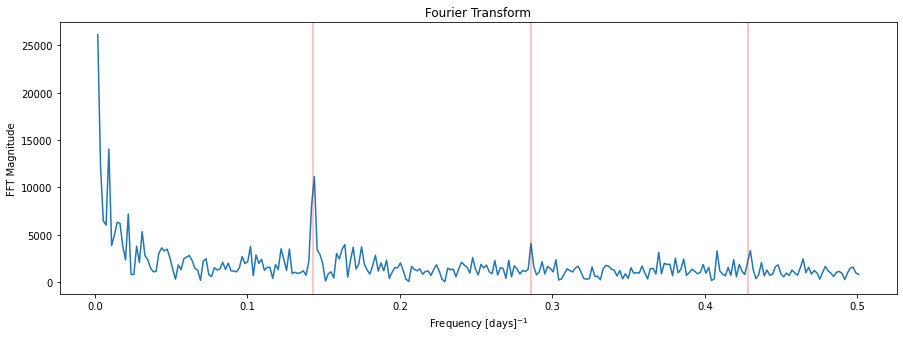

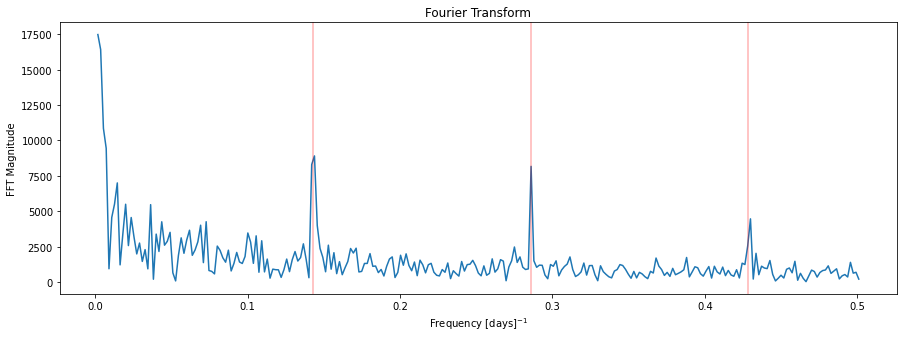

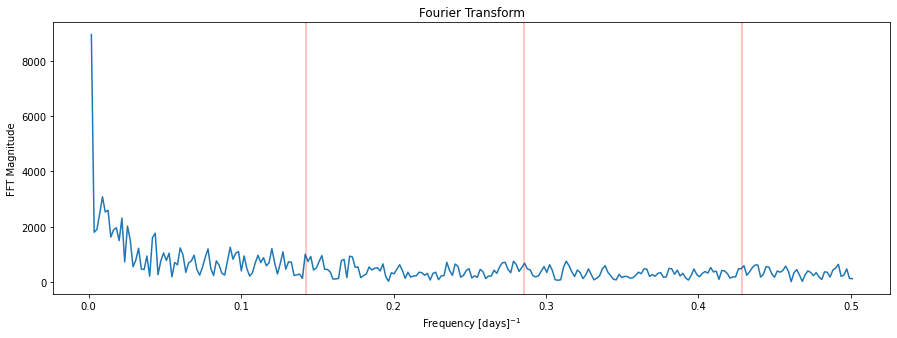

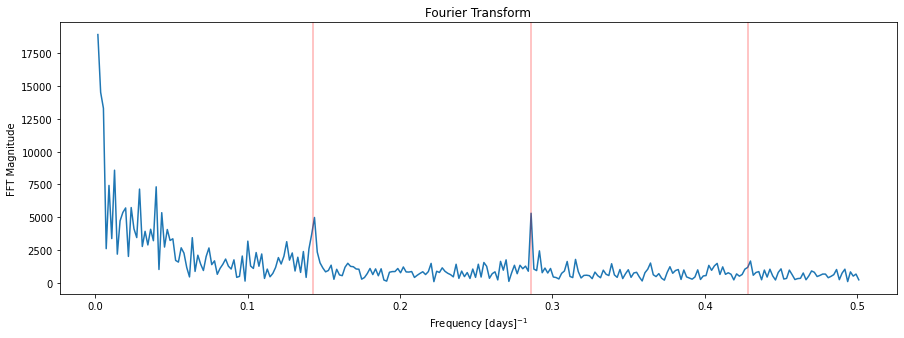

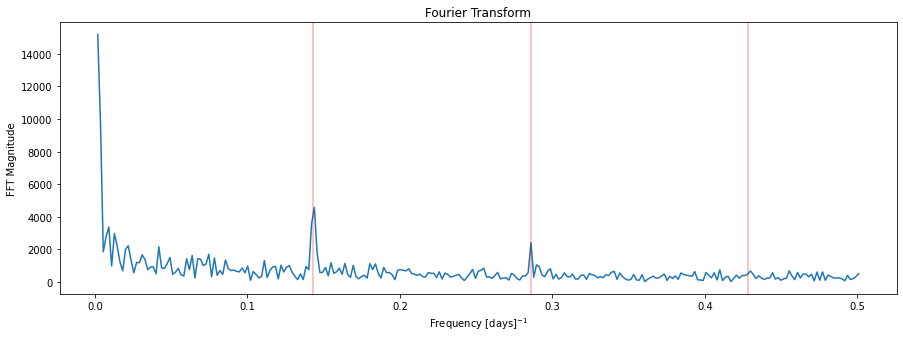

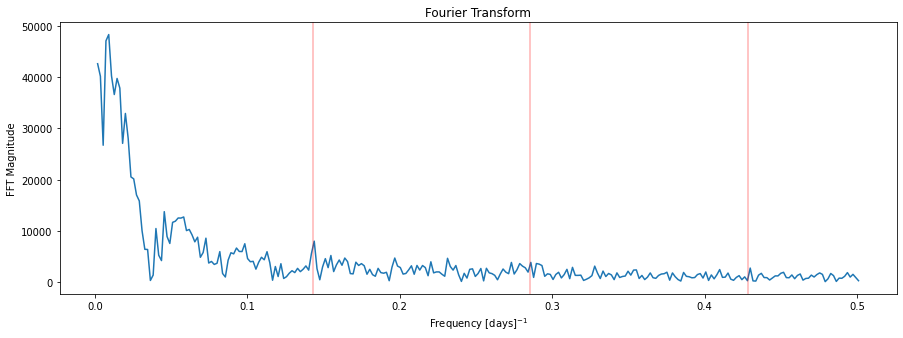

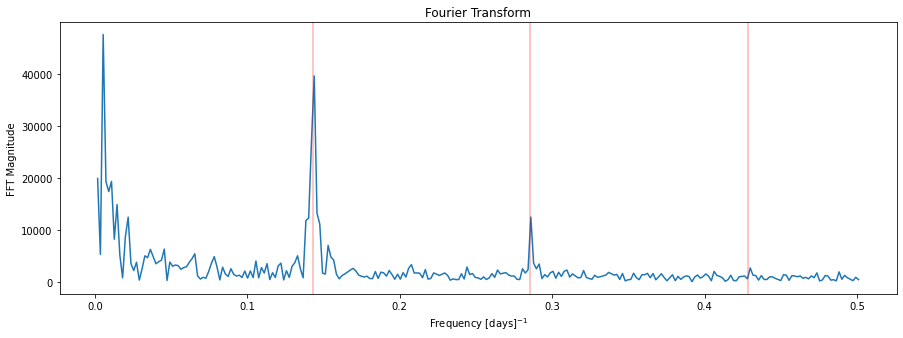

In [20]:
for key in sums:
    plot_with_fft(key)

Conslusion: 

After seen both the plots their is Spanish data has the strongest periodic features, most of the other languages show some periodicity as well. For some reason the Russian and media data do not seem to show much. Plotted red lines where a period of 1, 1/2, and 1/3 week would appear. See that the periodic features are mainly at 1 and 1/2 week. This is not surprising since browsing habits may differ on weekdays compared to weekends, leading to peaks in the FFTs at frequencies of n/(1 week) for integer n. It shows that page views are not at all smooth. There is some regular variation from day to day, but there are also large effects that can happen quite suddenly. A model likely will not be able to predict the sudden spikes unless it can be fed more information required about what is going on currently.

<h2>Individual Entry Data</h2>

Now, plot the data for some individual entries. Picked some entries to look at, but there's not necessarily anything special about them.

In [30]:
def plot_entry(key,idx):
    data = lang_sets[key].iloc[idx,1:]
    fig = plt.figure(1,figsize=(10,5))
    plt.plot(x,data)
    plt.xlabel('dates')
    plt.ylabel('Time spent')
    plt.title(train.iloc[lang_sets[key].index[idx],0])
    
    plt.show()

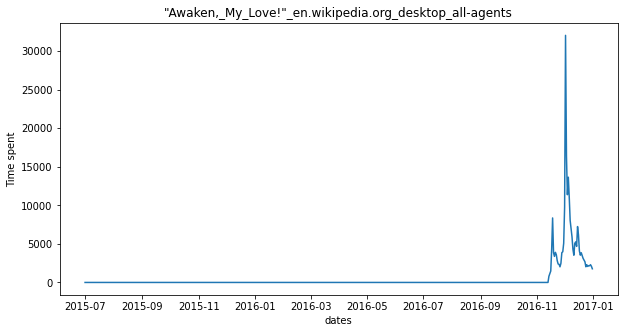

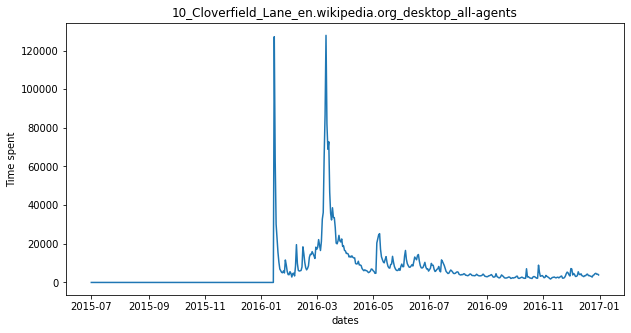

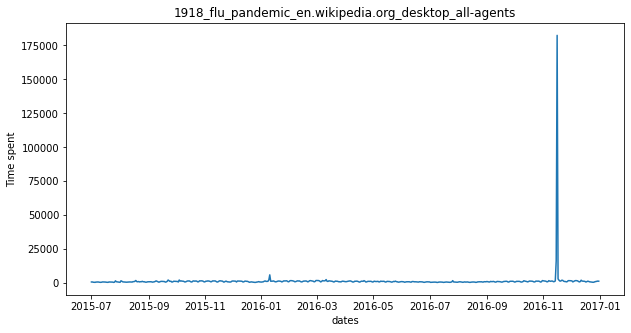

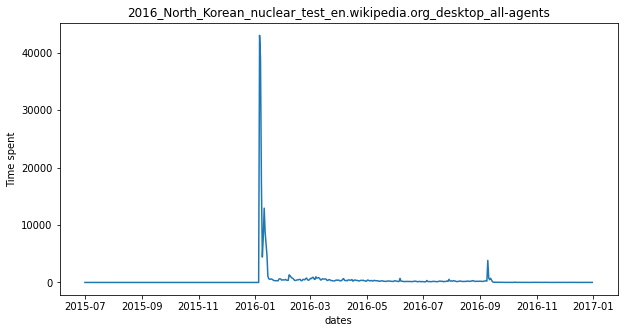

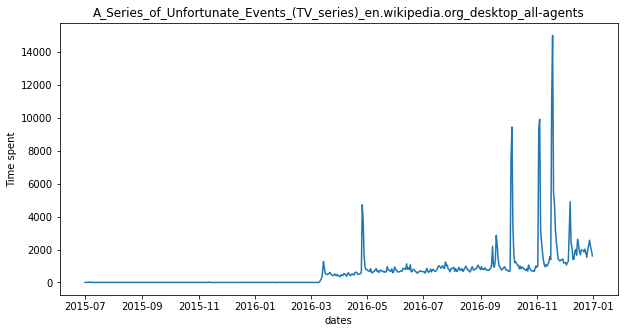

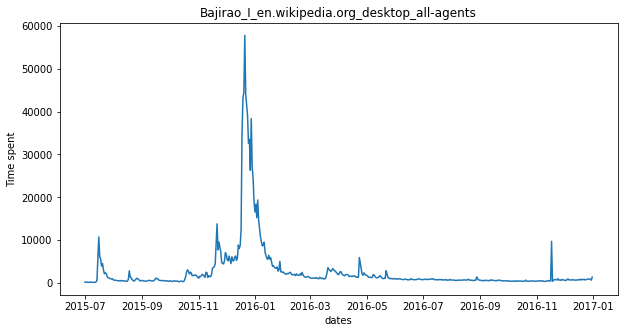

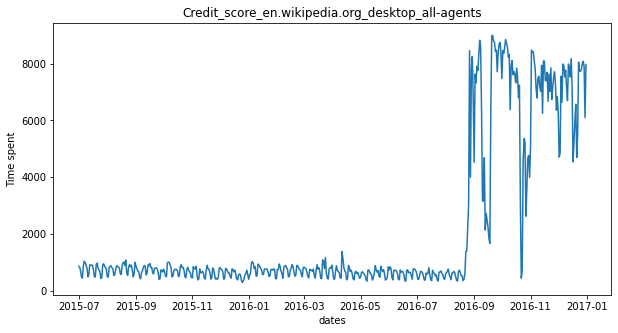

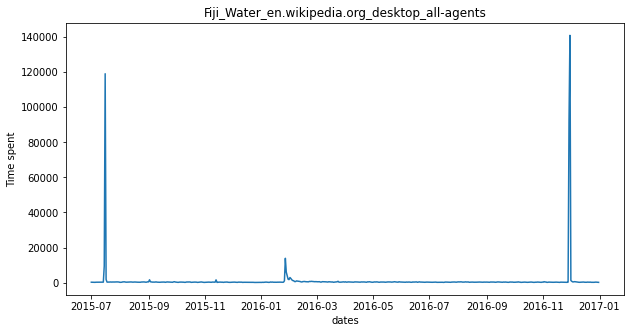

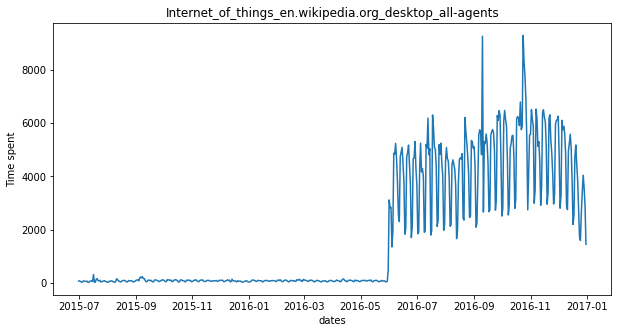

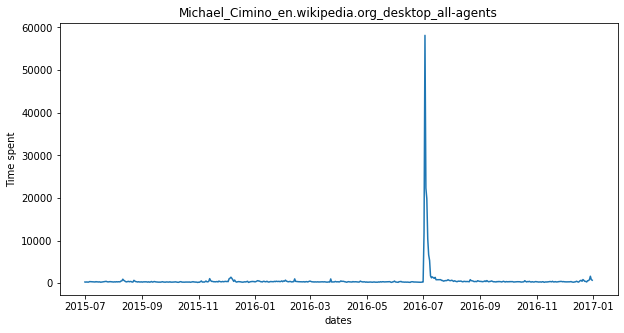

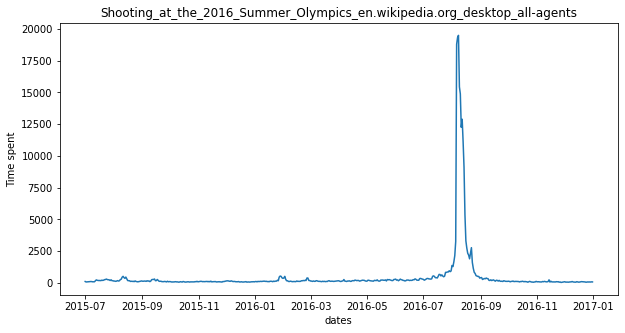

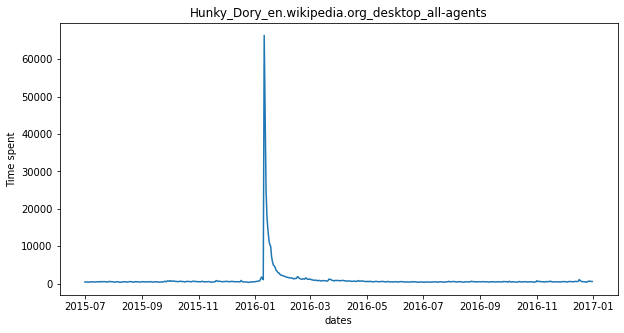

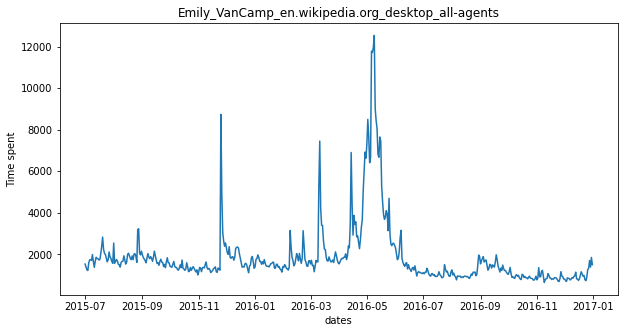

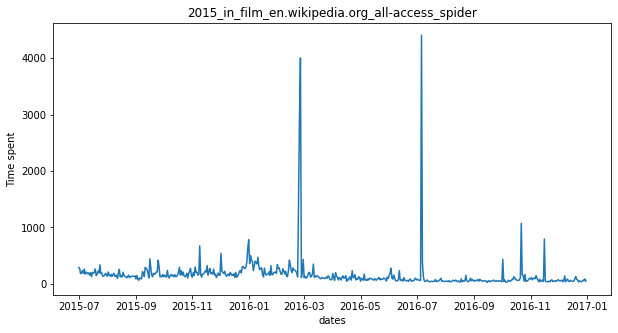

In [31]:
#First, let's look at some English pages

idx = [1, 5, 10, 50, 100, 250,500, 750,1000,1500,2000,3000,4000,5000]
for i in idx:
    plot_entry('en',i)

Conclusion:

From above plot, see that for individual pages, the data is also not smooth. There are sudden gigantic spikes, large shifts in the mean number of views, and other things. Also clearly see the effects of current events on Wikipedia views.

The 2016 North Korean nuclear test occurred, and a Wikipedia page was quickly constructed and received a huge number of views in a short time. The number of views mostly decayed away in 1 or 2 weeks.

Hunky Dory received a large number of viewers around the beginning of 2016, corresponding to the death of David Bowie.

The page about the shooting competition at the 2016 Olympics had a small number of views and then suddenly a lot right around the Olympics.

There are also some oddities, like two huge spikes in the data for Fiji Water, and the sudden long-term increases in traffic to "Internet of Things" and "Credit score." Maybe there were some news stories about Fiji water on those days. For the others, maybe there was a change in search engine behavior or maybe some new links appeared in very visible locations.

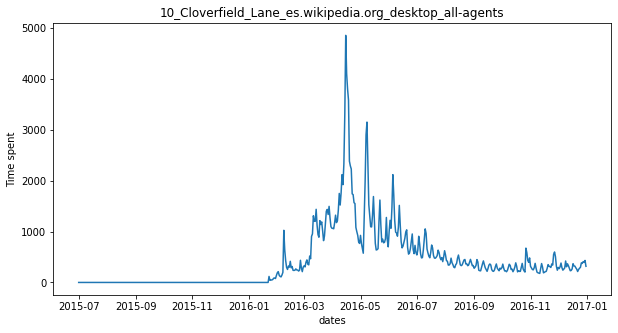

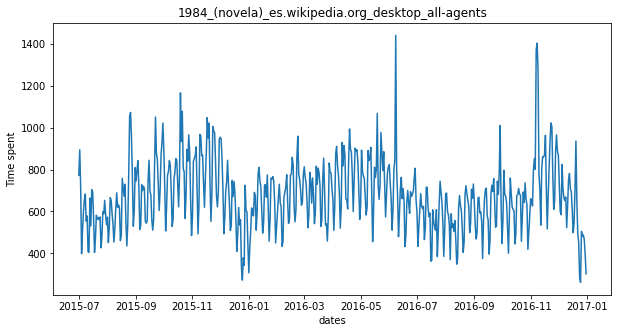

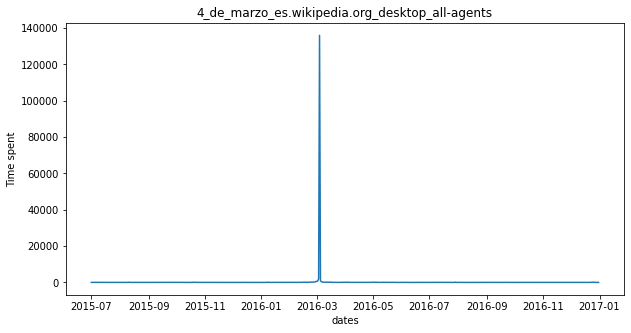

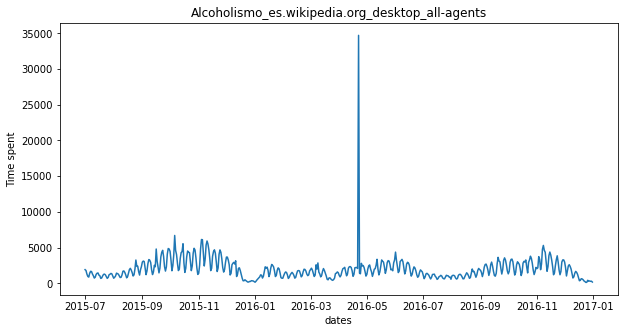

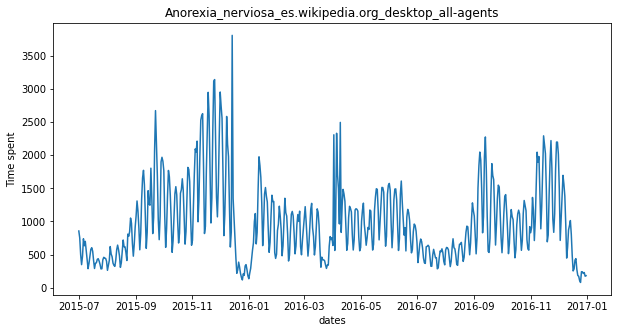

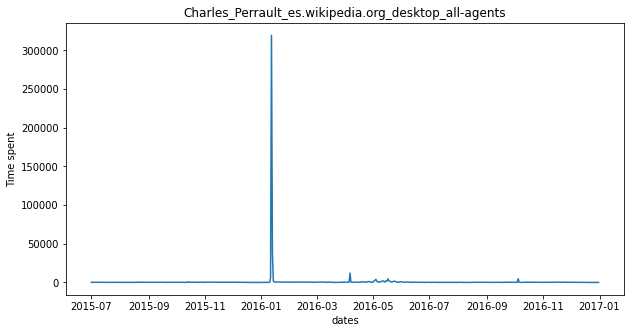

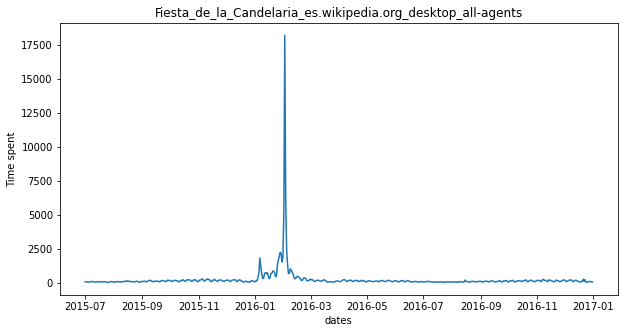

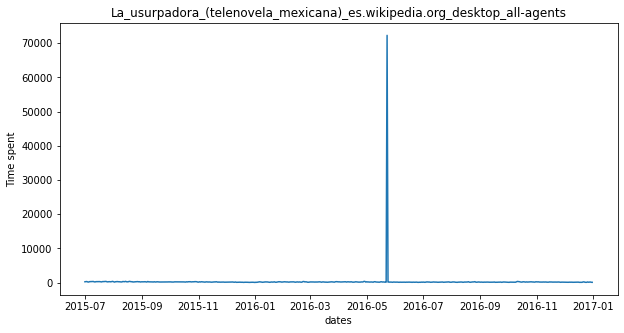

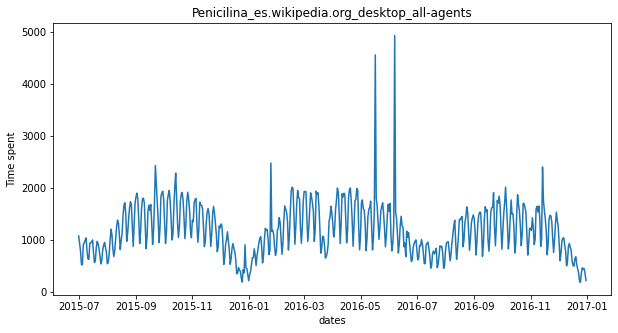

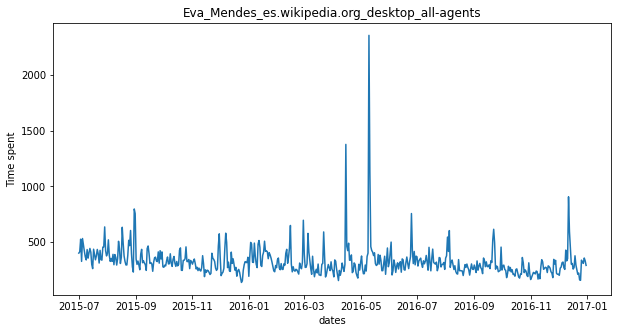

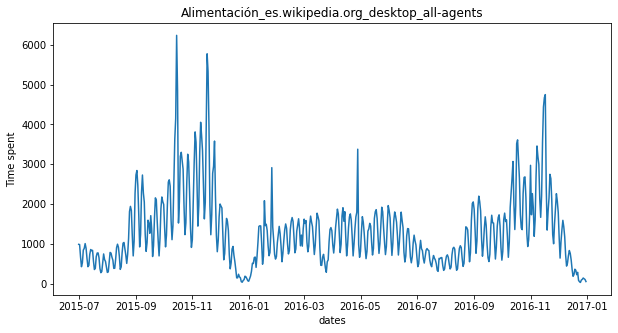

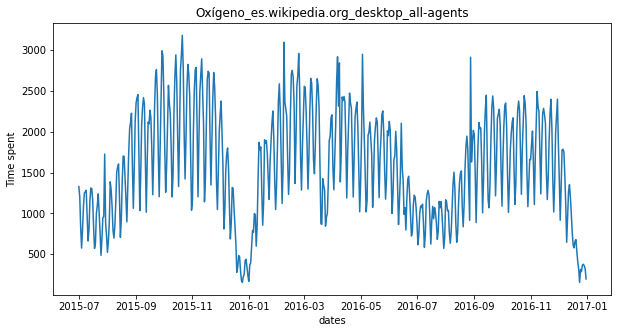

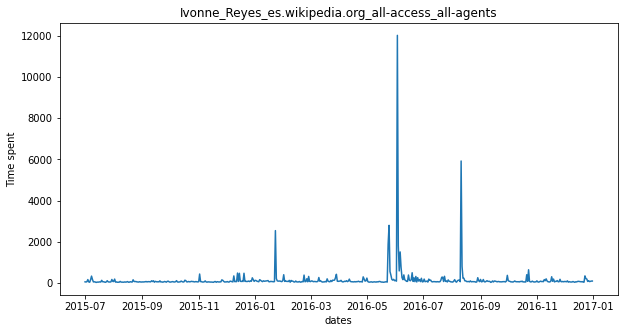

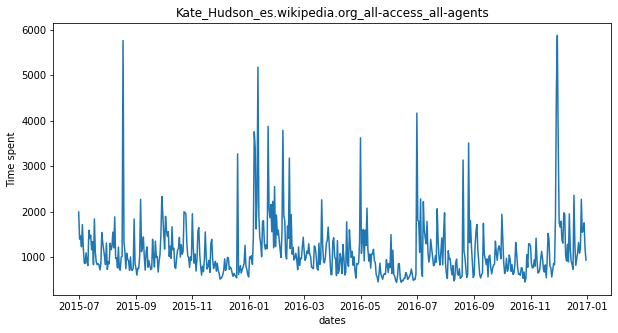

In [32]:
#Now look at some Spanish entries

idx = [1, 5, 10, 50, 100, 250,500, 750,1001,1500,2000,3000,4000,5000]
for i in idx:
    plot_entry('es',i)

Conclusion:

This shows even more extreme short-term spikes than the English data. If some of these are just one or two days before reverting back to the mean, they may be a sign that something is wrong with the data. To deal with extremely short spikes, which we almost certainly won't be able to predict, something like a median filter can be used to remove them.

We see something very curious here, though. We see that a very strong periodic structure appears only in certain pages. The plots showing the strongest periodic structure actually all have something in common - they all seem to have something to do with health topics. The weekly structure might make sense if it's related to people seeing doctors and then consulting Wikipedia.

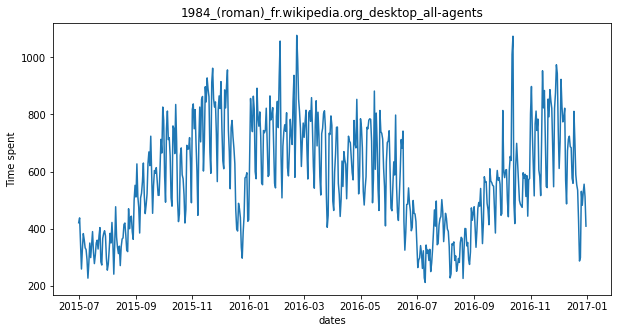

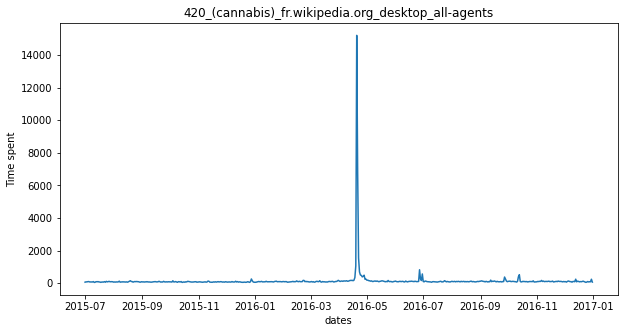

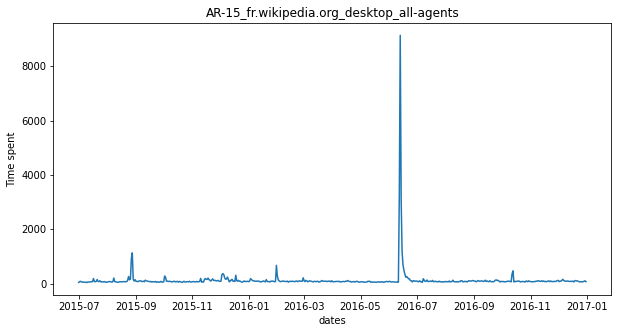

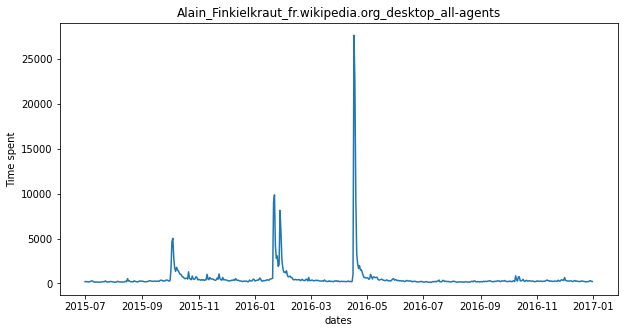

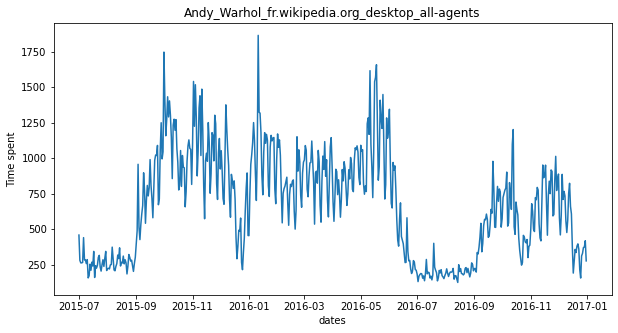

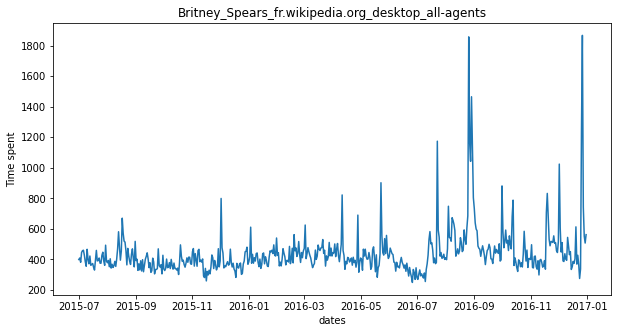

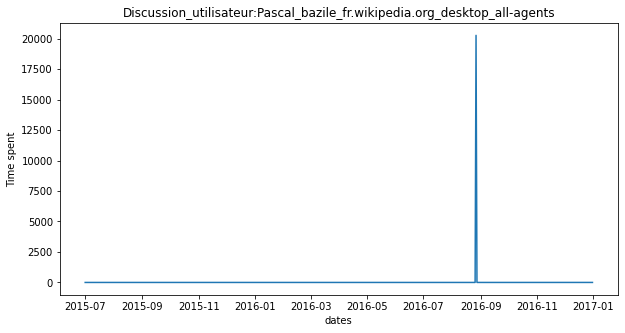

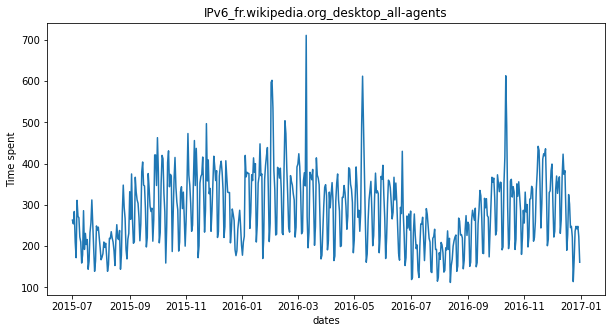

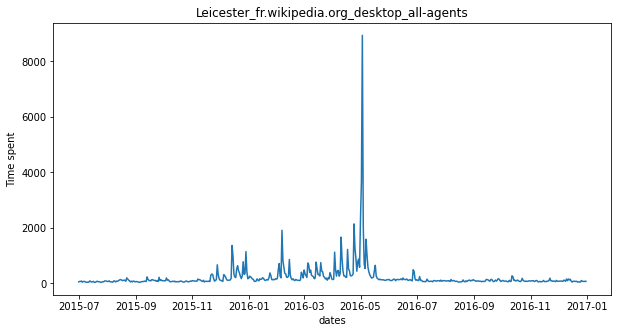

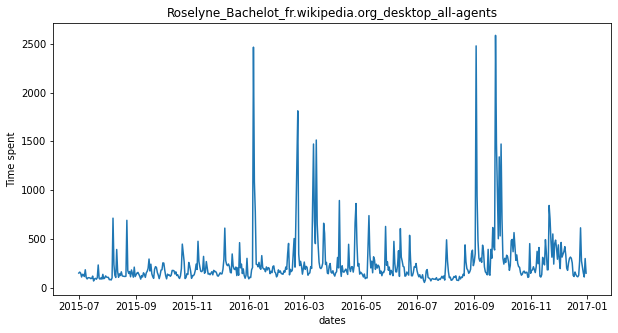

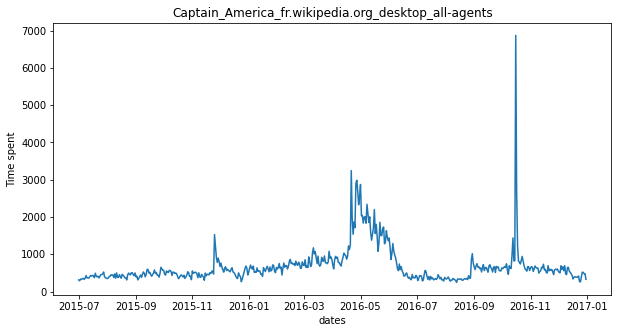

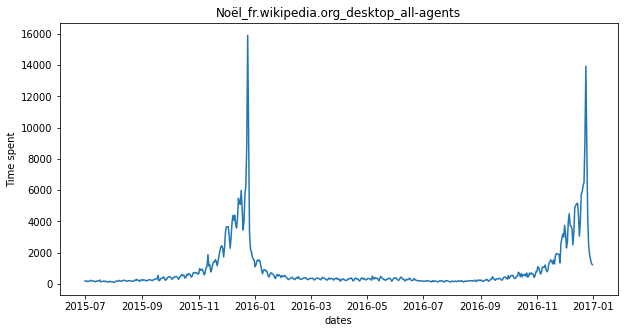

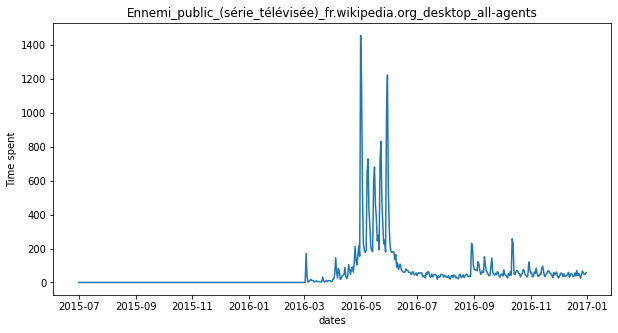

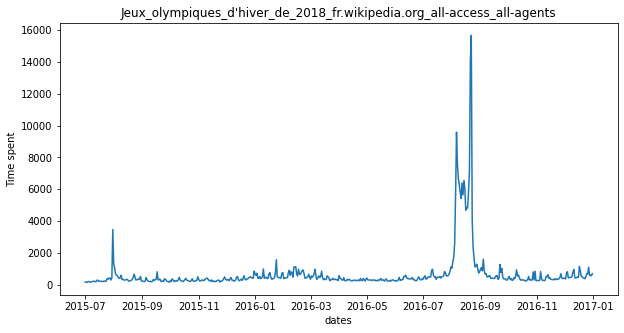

In [33]:
#Now look at some french entries
indx = [1, 5, 10, 50, 100, 250,500, 750,1001,1500,2000,3000,4000,5000]
for i in indx:
    plot_entry('fr',i)

Conclusion:

The French plots show more of the same. Wikipedia views again are hugely dependent on whether or not something is in the news. Leicester FC won the Premier League and received many page views around the championship. The Olympics caused a huge spike in traffic to their page. Christmas actually shows some interesting structure, with views steadily increasing throughout Advent.

<h3>Does the aggregated data compare to the most popular pages?</h3>

Some of the potential problems with the aggregated data, so now look at the most popular pages, which are generally going to be the main pages for the languages in this dataset.

In [34]:
# For each language get highest few pages
npages = 5
top_pages = {}
for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total',ascending=False)
    print(sum_set.head(10))
    top_pages[key] = sum_set.index[0]
    print('\n\n')

en
                                                    Page         total
38573   Main_Page_en.wikipedia.org_all-access_all-agents  1.206618e+10
9774       Main_Page_en.wikipedia.org_desktop_all-agents  8.774497e+09
74114   Main_Page_en.wikipedia.org_mobile-web_all-agents  3.153985e+09
39180  Special:Search_en.wikipedia.org_all-access_all...  1.304079e+09
10403  Special:Search_en.wikipedia.org_desktop_all-ag...  1.011848e+09
74690  Special:Search_en.wikipedia.org_mobile-web_all...  2.921628e+08
39172  Special:Book_en.wikipedia.org_all-access_all-a...  1.339931e+08
10399   Special:Book_en.wikipedia.org_desktop_all-agents  1.332859e+08
33644       Main_Page_en.wikipedia.org_all-access_spider  1.290204e+08
34257  Special:Search_en.wikipedia.org_all-access_spider  1.243102e+08



ja
                                                     Page        total
120336      メインページ_ja.wikipedia.org_all-access_all-agents  210753795.0
86431          メインページ_ja.wikipedia.org_desktop_all-agents  134147415

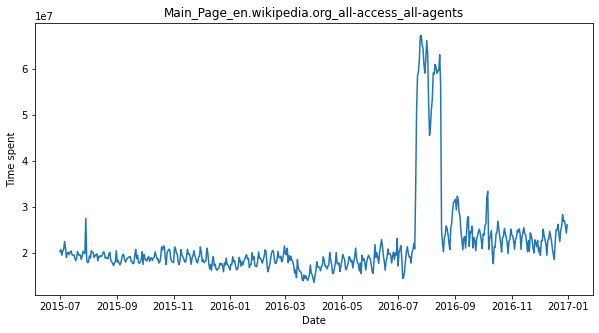

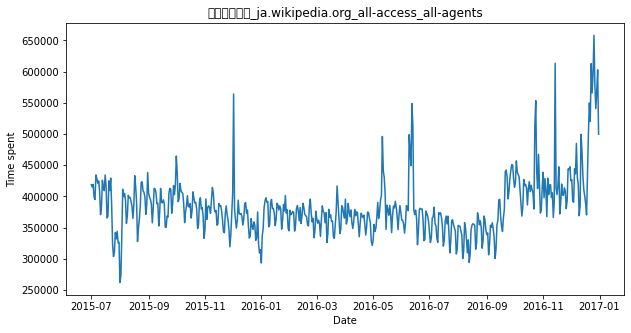

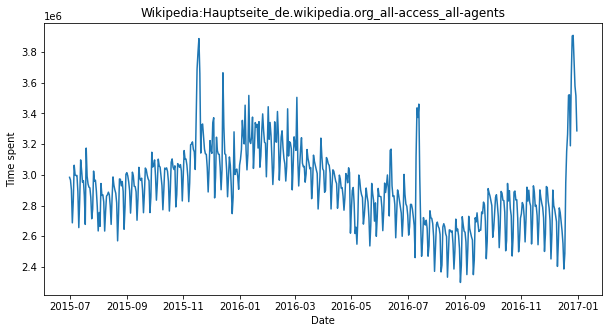

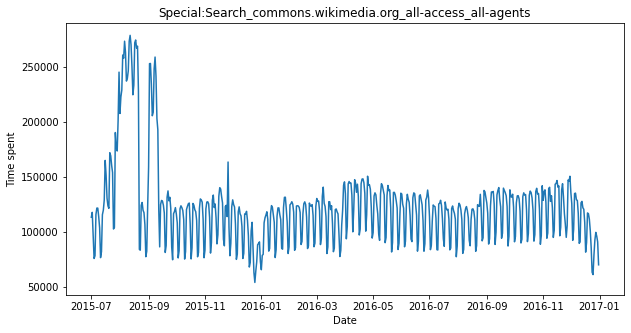

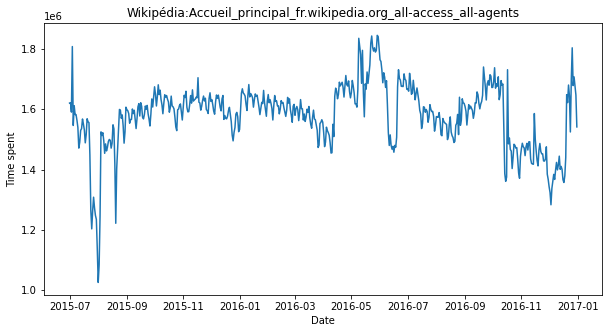

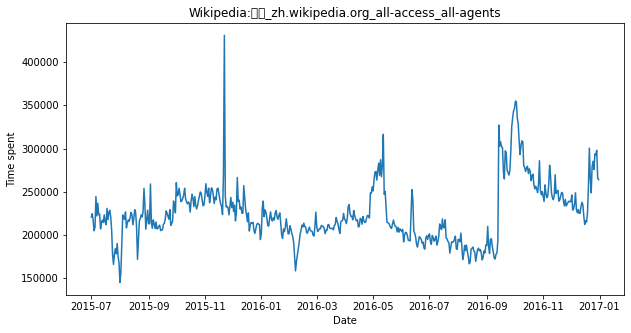

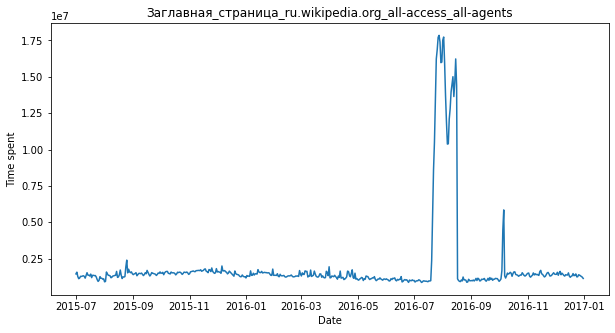

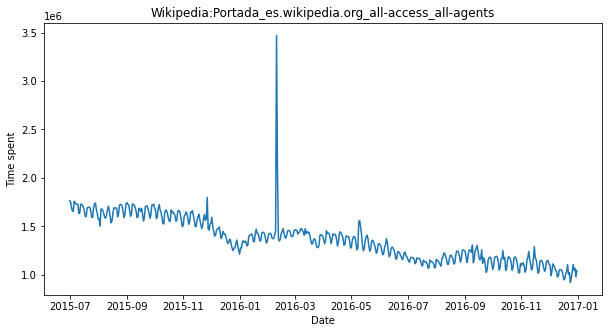

In [35]:
for key in top_pages:
    fig = plt.figure(1,figsize=(10,5))
    cols = train.columns
    cols = cols[1:-1]
    data = train.loc[top_pages[key],cols]
    plt.plot(x,data)
    plt.xlabel('Date')
    plt.ylabel('Time spent')
    plt.title(train.loc[top_pages[key],'Page'])
    plt.show()

Conclusion:

Comparing these to the aggregated data, see that things are mostly pretty similar. It show that the Olympics would have such a huge effect on a site like Wikipedia. Would say that the Japanese, Spanish, and media data differ the most. For media pages, most people will access pages via links from other sites rather than through the main page or search function. The fact that some of the languages show large differences between the main page and the aggregated data suggests that the dataset is perhaps not very representative of all traffic to Wikipedia.

Lets check how many unique page are present

In [37]:
unique_page = train['Page'].unique()

In [39]:
print(unique_page.shape)

(145063,)


Each article name has the following format: 'name_project_access_agent' . That would be a good idea to separate out all these 4 features to get more better understanding of data

In [40]:
page_details = pd.DataFrame([i.split("_")[-3:] for i in train["Page"]])
page_details.columns = ["project", "access", "agent"]
page_details.describe()

,project,access,agent
count,145063,145063,145063
unique,9,3,2
top,en.wikipedia.org,all-access,all-agents
freq,24108,74315,110150


As we can see there are 9, 3 and 2 unique values for project, access and agent respectively. looking on these values

In [41]:
project_columns = page_details['project'].unique()
access_columns = page_details['access'].unique()
agents_columns = page_details['agent'].unique()
print(list(page_details['project'].unique()))
print(list(page_details['access'].unique()))
print(list(page_details['agent'].unique()))

['zh.wikipedia.org', 'fr.wikipedia.org', 'en.wikipedia.org', 'commons.wikimedia.org', 'ru.wikipedia.org', 'www.mediawiki.org', 'de.wikipedia.org', 'ja.wikipedia.org', 'es.wikipedia.org']
['all-access', 'desktop', 'mobile-web']
['spider', 'all-agents']


In [42]:
#merging a page details with train data and creating new dataframe

train_df = train.merge(page_details, how="inner", left_index=True, right_index=True)

ploted the project wise monthly mean hits

In [43]:
def graph_by(plot_hue, graph_columns):
    train_project_df = train_df.groupby(plot_hue).sum().T
    train_project_df.index = pd.to_datetime(train_project_df.index)
    
    train_project_df = train_project_df.groupby(pd.Grouper(freq='M')).mean().dropna()
    train_project_df['month'] = 100*train_project_df.index.year + train_project_df.index.month
    train_project_df = train_project_df.reset_index(drop=True)
    train_project_df = pd.melt(train_project_df, id_vars=['month'], value_vars=graph_columns)
    fig = plt.figure(1,figsize=[12,10])
    ax = sns.pointplot(x="month", y="value", hue=plot_hue, data=train_project_df)
    ax.set(xlabel='Year-Month', ylabel='Mean Hits')

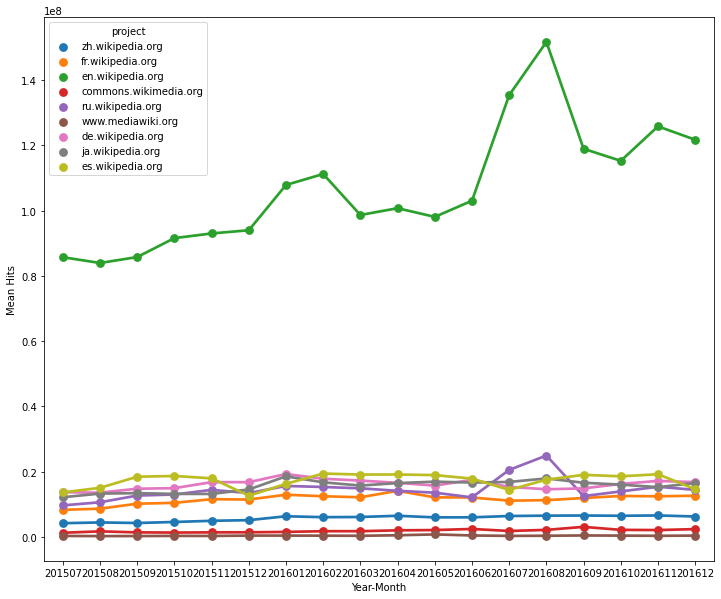

In [44]:
graph_by("project", project_columns)

Conclusion:

English Wikipedia project hitting more than any other project. Also, Russian Wikipedia is having same hike near to august 2016 as English Wikipedia.


Now with English project in graph, it is hard to visualise other projects. Separated out English project and find some patterns if possible.

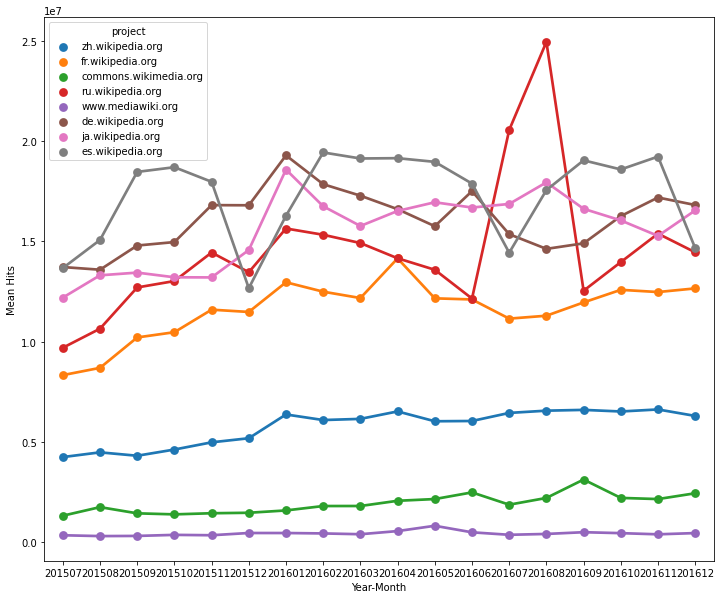

In [45]:
graph_by("project", [x for i,x in enumerate(project_columns) if i!=2])

Conclusion:

it clearlly showing that media pages are rarely visitied by users but here some hikes are showing in the russion page in the 2016 year in june month.


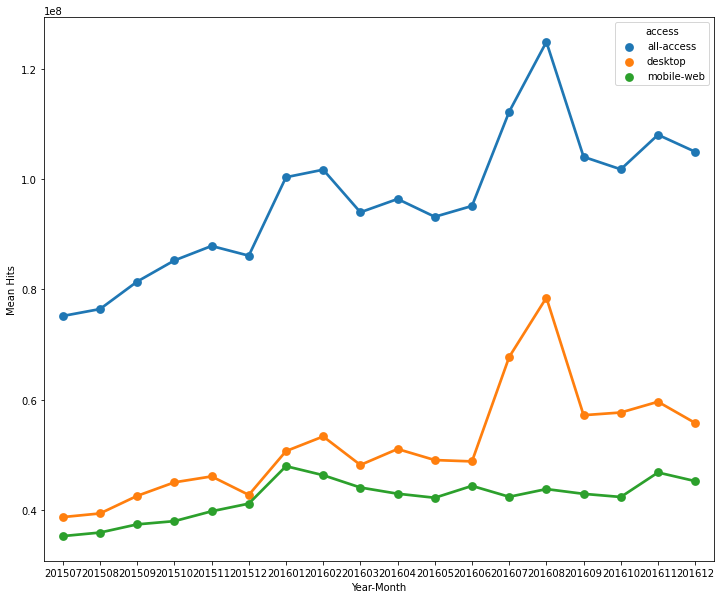

In [46]:
# looks for the access
graph_by("access", access_columns)

Conclusion:

All the pages are accessed but the desktop more rigorously then the mobile users. People prefer to access through the desktop.

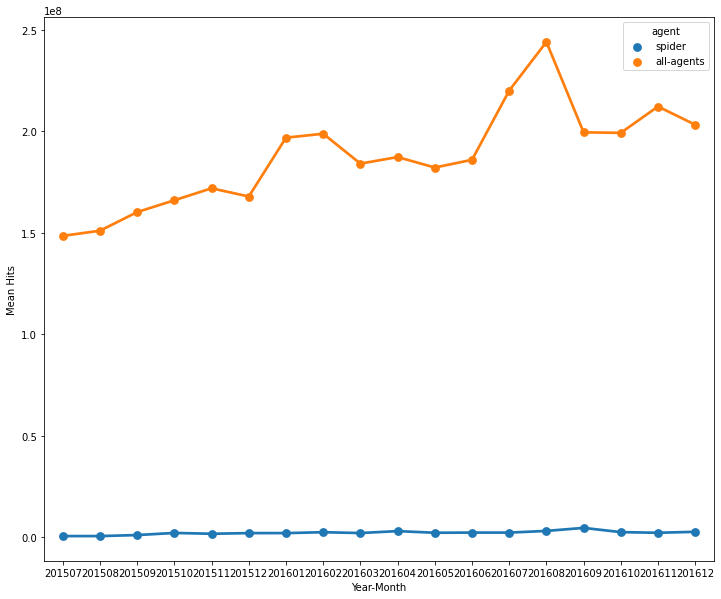

In [47]:
graph_by("agent", agents_columns)

Conclusion:

We could not get data pattern from above graph. With just two values for agent why not get them plotted in two separate graphs and see how they behave.

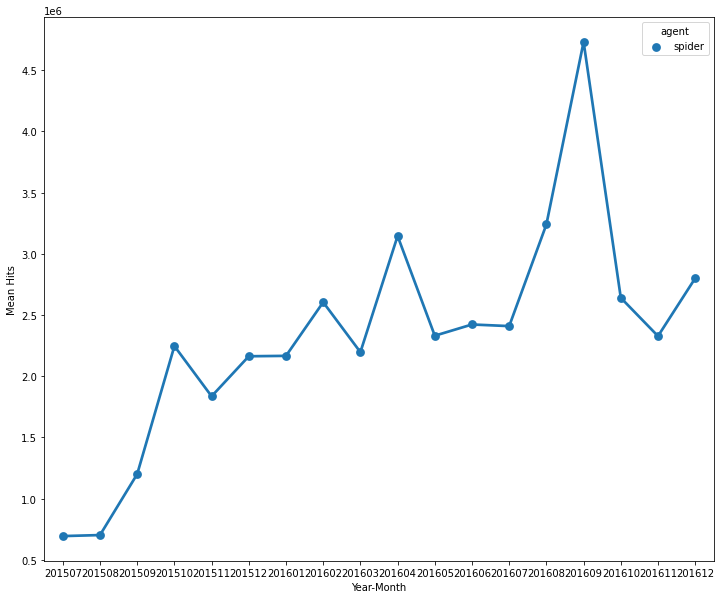

In [48]:
graph_by("agent", agents_columns[0])

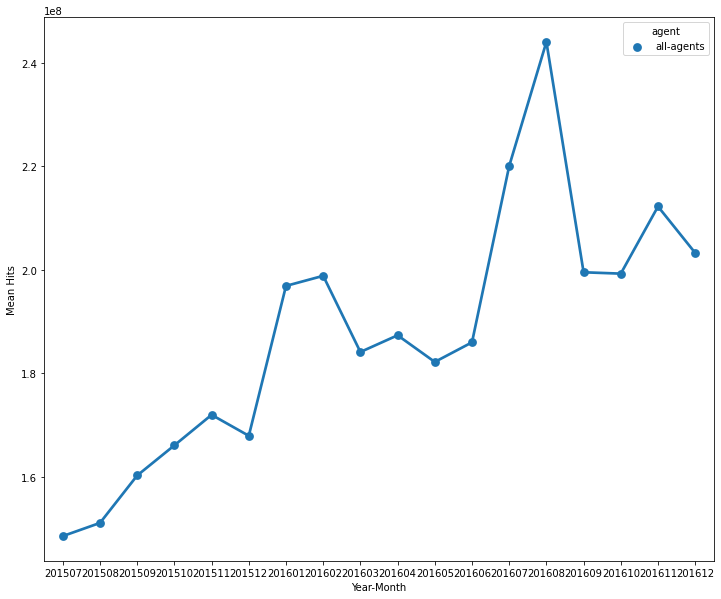

In [49]:
graph_by("agent", agents_columns[1])

Conclusion:

All-access and all-agents value for access and agents are summation of values for respective attributes. So each value other than all-access contribute in trend for all-access and all values other than all-agents contribute in trend of all-agents.

We have seen the every kind of pattern that our data exhibit. Now, we will try to answer some question based on our data which can prove helpful at later stages of our project.

<h3>Which month has more visits on an average ?</h3>

From here onwards every question that we will try to answer, their average will be based on Median and not on mean.

In [50]:

month=[]
for i in tnrange(12):
    k=[]
    month.append(k)

for col in tqdm(train.columns[1:-1]):
    
    index=int(col.split('-')[1])
    
    month[index-1].append(np.median(train[col].values))
    
for i in range(len(month)):
    month[i]=np.median(month[i])
print(month)
print('Month with most number of average visitor is ', month.index(max(month))) 

 10%|█         | 55/550 [00:00<00:00, 546.23it/s]

100%|██████████| 550/550 [00:00<00:00, 556.22it/s]

[113.0, 118.0, 118.0, 123.0, 127.0, 126.0, 90.5, 93.0, 104.5, 108.0, 110.5, 111.0]
Month with most number of average visitor is  4


So, index 4 is for May which shows on an average May has most number of visits. In comparision to July which has least number of average visitors, May shows a significant 25 % growth.

In [51]:

# Here, we will check which day of the week has most number of visits on average.
week_day=[]
for i in tnrange(7):
    k=[]
    week_day.append(k)
for col in tqdm(train.columns[1:-1]):
    index=datetime.datetime.strptime(' '.join(col.split('-')), '%Y %m %d').weekday() 
    week_day[index].append(np.median(train[col].values))
 
for i in range(len(week_day)):
    week_day[i]=np.median(week_day[i])
print(week_day)    
print('Day with maximum average visitors: ',calendar.day_name[week_day.index(max(week_day))])


 10%|▉         | 54/550 [00:00<00:00, 534.58it/s]

100%|██████████| 550/550 [00:00<00:00, 555.62it/s]

[124.5, 123.0, 121.0, 119.0, 118.0, 119.0, 128.0]
Day with maximum average visitors:  Sunday


We can see that on an average Sunday has the most number of visitors but all of them are pretty close and don’t have much difference.

<h3>Does holiday season affects number of average visitors ?</h3>

As last 3 month of the year has most number of festivals all over the world. Lets check if it affects the average visitors.

In [52]:
# As we know that last 3 month of the year has most number of festivals all over the world. Lets check if it affects the average visitors.
month=[]
for i in tnrange(2):
    month.append([])
for col in tqdm(train.columns[1:-1]):
    index=int(col.split('-')[1])
    if(index<10):
        month[0].append(np.median(train[col].values))
    else:
        month[1].append(np.median(train[col].values))
     
for i in range(len(month)):
    month[i]=np.median(month[i])
print('\n')
print(month)    

 10%|█         | 55/550 [00:00<00:00, 547.30it/s]

100%|██████████| 550/550 [00:00<00:00, 569.00it/s]



[121.0, 111.0]


There is some difference here. There is actually 7.3 % dip in average number of visitors during holiday season.

Conclusion- That it actually make difference, during the holiday season, Wikipedia pages has less traffic in comparision to other months of the year.